In [1]:
# we can use multiple data sources for this
# Flukebook
from __future__ import division, print_function
from os.path import join, exists
import cPickle as pickle
import cv2
import numpy as np


with open('../dataset_loc', 'r') as f:
    dataset_loc = f.read().rstrip()
    
with open(join(dataset_loc, 'Flukes/Flukebook/flukebook_points_orig.pkl'), 'r') as f:
    fb_points = pickle.load(f)
print(len(fb_points))

2705


In [2]:
# Zooniverse
with open(join(dataset_loc, 'ibs_points_allindv.pkl'), 'r') as f:
    zsl_points = pickle.load(f)
    
print(zsl_points.keys())

[u'CINMS_20120617_A6698.jpg', u'CRC20110727-CTC-IMG_0143.jpg', u'10188-JAC88-78-14.jpg', u'11-14c-NB.jpg', u'20090727-JAC-0031.jpg', u'PStap130606fr9752_S3_FL_Mn_1.jpg', u'CINMS-20090327-A0940.jpg', u'DSC_6084.jpg', u'20120528-DB-4250.jpg', u'10934-NB96-17-16.jpg', u'10243-TEC99-43-10A.jpg', u'11710-EAF-20051118-C-0042.jpg', u'20090727-JAC-0045.jpg', u'10513-JAC92-41-14.jpg', u'11270-TEC102404_005.jpg', u'11262-NB98-903-16.jpg', u'20100806-JAC-0131.jpg', u'BG-20120815-9964.jpg', u'20090727-JAC-0289.jpg', u'20090826-JAC-0114.jpg', u'BG-20120912-3026.jpg', u'20110726-JAC_0078.jpg', u'11211-JAC03-090103-087.jpg', u'KIO_081909_Page_38.jpg', u'20130425-DB-LA3A0385.jpg', u'12084-PStap051105fr5746.jpg', u'WG-20140225-BR-AK-0808.jpg', u'10173-KCB87-77-20.jpg', u'20100509-D16-0350.jpg', u'10044-JAC92-49-03.jpg', u'10550-TEC91-02-06.jpg', u'14070-20070704-ABD_0016edit.jpg', u'13775-20061010-GSS-0015EDIT.jpg', u'12541-20080916-EAF-0122EDIT.jpg', u'12162-GT020306-CAG-0013.jpg', u'BG-20120710-e5-73

In [3]:
# Our own annotations
from glob import glob
import json
annotation_path = "/home/andrew/envs/whaleFlukes/whale_edge_annotations/annotation_info"

all_annotations = glob(join(annotation_path, '*'))
annotation_points = []
for annotation_fn in all_annotations:
    with open(annotation_fn, 'r') as f:
        annotation = json.load(f)
        if annotation[1]['done'] and not annotation[1]['bad'] and not annotation[1]['notchSubmerged']:
            this_annot = {'fn':annotation[0]}
            this_annot['left'] = annotation[1]['topInfo']['path'][-1]
            this_annot['right'] = annotation[1]['topInfo']['path'][0]
            this_annot['notch'] = annotation[1]['notch']
            annotation_points.append(this_annot)
print(len(annotation_points))

490


In [4]:
fb_imgs_dir = join(dataset_loc, "Flukes/Flukebook/images")
zsl_and_annot_imgs_dir  = join(dataset_loc, "Flukes/CRC_combined constrained")

In [5]:
# come up with a set of annotations that are part of the annotcfg mingt=2 (i.e., our evaluation set), and filter those out
from collections import defaultdict
id_img_map = defaultdict(lambda : [])
for i in fb_points:
    id_img_map[i['id']].append(i['fn'])

In [6]:


#fixed_shape = (224, 224) # so I can transfer over Imagenet trained models
#fixed_shape = (128, 128) # so I can minimize size of network
#fixed_shape = (256, 256) # bit bigger
fixed_shape = (64, 64) # small for posterity


def resize_point(new_shape, old_shape, point):
    # check that the point is inside the bounds of the image
    if ((point[0] < 0) or (point[0] > old_shape[1])) or ((point[1] < 0) or (point[1] > old_shape[0])):
        print("Point %s is out of bounds for shape %s" % (point, old_shape))
        raise IndexError("Point is out of bounds")
    # assume point is x, y
    scale_x = new_shape[1] / old_shape[1]
    scale_y = new_shape[0] / old_shape[0]
    
    new_pt = np.array([int(point[0]*scale_x), int(point[1]*scale_y)]).reshape(1,-1)
    return new_pt

def convert_img_points(new_size, img, left, right, notch):
    # assume new_size is y, x (makes sense for everything except cv2)
    resized_img = cv2.resize(img, new_size[::-1], cv2.INTER_LANCZOS4)

    resized_left = resize_point(new_size, img.shape, left)
    resized_right = resize_point(new_size, img.shape, right)
    resized_notch = resize_point(new_size, img.shape, notch)
    
    return resized_img, np.vstack([resized_left, resized_right, resized_notch])
    
xyc = lambda pt: (pt['x'], pt['y'])
def resize_x(new_x, img):
    # resize keeping aspect ratio
    try:
        ratio = img.shape[1] / img.shape[0]
        new_y = int(new_x / ratio)
    except ZeroDivisionError:
        raise ZeroDivisionError("One of the image shapes is 0")
    return (new_y, new_x)
fixed_x = 960
    
# these need to stay parallel
fb_kp_imgs = []
fb_kp_pts = []
fb_kp_sizes = []




for annot in fb_points:
    if (annot['id'] != '____') and (len(id_img_map[annot['id']]) > 1):
        continue
    img = cv2.cvtColor(cv2.imread(join(fb_imgs_dir, annot['fn'])),cv2.COLOR_BGR2GRAY)
    rescaled_shape = resize_x(fixed_x, img)
    try:
        resized_img, res_points = convert_img_points(fixed_shape, img, 
                                         xyc(annot['points']['left']), xyc(annot['points']['right']), 
                                                                         xyc(annot['points']['notch']))
    except IndexError as ie:
        print("Bad points on image %s" % annot['fn'])
        continue
    fb_kp_imgs.append(resized_img)
    fb_kp_pts.append(res_points)
    fb_kp_sizes.append((rescaled_shape,join(fb_imgs_dir, annot['fn'])))
# guide: so each of <src>_kp_pts is going to be a matrix where each row is the x, y coords of each point in 
# left, right, notch respectively

Point (2274, 161) is out of bounds for shape (600, 800)
Bad points on image extractacec3374-a75b-4ade-a6c0-dd3bb9232430.jpg
Point (1220, 126) is out of bounds for shape (600, 800)
Bad points on image extractb3691432-954e-4c15-a5f9-42a45f310880.jpg
Point (2690, 28) is out of bounds for shape (600, 800)
Bad points on image extractbfb38ee7-6b40-48a1-8820-b26403469492.jpg
Point (2019, 80) is out of bounds for shape (683, 1968)
Bad points on image extractd2d2bbea-dd11-4ec1-94cb-e2c24a2e77ba.jpg
Point (1923, 28) is out of bounds for shape (600, 800)
Bad points on image extractd3621134-50d0-4dd8-b4b3-43363552413c.jpg
Point (2003, 144) is out of bounds for shape (600, 800)
Bad points on image extractd38d845f-d468-4658-99af-856b9d729583.jpg
Point (2396, 103) is out of bounds for shape (600, 800)
Bad points on image extracte3977b88-ee22-43a7-9f4f-1f4ff0a35891.jpg
Point (1698, 19) is out of bounds for shape (600, 800)
Bad points on image extracte6ab0c45-a37f-4d65-bf38-071b2ec550e4.jpg
Point (995,

In [7]:
zsl_kp_imgs = []
zsl_kp_pts = []
zsl_kp_sizes = []

seen_imgs = set()

zsl_points.keys()

for imgn in zsl_points:
    img = cv2.cvtColor(cv2.imread(join(zsl_and_annot_imgs_dir, imgn)),cv2.COLOR_BGR2GRAY)
    rescaled_shape = resize_x(fixed_x, img)
    resized_img, res_points = convert_img_points(fixed_shape, img,
                                        zsl_points[imgn]['left'], zsl_points[imgn]['right'], 
                                                                     zsl_points[imgn]['notch'])
    seen_imgs.add(imgn)
    zsl_kp_imgs.append(resized_img)
    zsl_kp_pts.append(res_points)
    zsl_kp_sizes.append((rescaled_shape, join(zsl_and_annot_imgs_dir, imgn)))

In [8]:
annot_kp_imgs = []
annot_kp_pts = []
annot_kp_sizes = []

for annot in annotation_points:
    if annot['fn'] in seen_imgs:
        print("Already saw %s in the ZSL data, skipping" % annot['fn'])
        continue
    if not exists(join(zsl_and_annot_imgs_dir, annot['fn'])):
        continue
    img = cv2.cvtColor(cv2.imread(join(zsl_and_annot_imgs_dir, annot['fn'])),cv2.COLOR_BGR2GRAY)
    rescaled_shape = resize_x(fixed_x, img)
    resized_img, res_points = convert_img_points(fixed_shape, img,
                                        annot['left'], annot['right'], annot['notch'])
    annot_kp_imgs.append(resized_img)
    annot_kp_pts.append(res_points)
    annot_kp_sizes.append((rescaled_shape,join(zsl_and_annot_imgs_dir, annot['fn'])))

Already saw 13716-RWB081604_1241.jpg in the ZSL data, skipping
Already saw 20120505-DB-4844.jpg in the ZSL data, skipping
Already saw CINMS_20120713_A7491.jpg in the ZSL data, skipping
Already saw 20100819-Frediani-6417.jpg in the ZSL data, skipping
Already saw 12413-IMG_1268.jpg in the ZSL data, skipping
Already saw JKJ-20120909-8605.jpg in the ZSL data, skipping
Already saw 11833-JAC-20050911-0058.jpg in the ZSL data, skipping
Already saw 10312-JAC01-61_13Edit.jpg in the ZSL data, skipping
Already saw CINMS-20090417-A2446.jpg in the ZSL data, skipping
Already saw 20101014-JAC-0164.jpg in the ZSL data, skipping
Already saw 11902-r043-39f03.jpg in the ZSL data, skipping
Already saw 20130930-DB-LA3A0580.jpg in the ZSL data, skipping
Already saw CRC20120513-CTC-IMG_1725.jpg in the ZSL data, skipping
Already saw BG-20120912-3026.jpg in the ZSL data, skipping
Already saw 20100729-JAC-0026.jpg in the ZSL data, skipping
Already saw 11791-TEC03-3-16.jpg in the ZSL data, skipping
Already saw 1

In [9]:
len(annot_kp_imgs)

262

In [10]:
print(len(fb_kp_imgs))
print(len(zsl_kp_imgs))
print(len(annot_kp_imgs))

1615
1970
262


In [11]:
from itertools import chain
all_kp_imgs = np.stack(list(chain(fb_kp_imgs, zsl_kp_imgs, annot_kp_imgs)), axis=0)
all_kp_pts = np.stack(list(chain(fb_kp_pts, zsl_kp_pts, annot_kp_pts)), axis=0)
all_kp_sizes = np.stack(list(chain(fb_kp_sizes, zsl_kp_sizes, annot_kp_sizes)), axis=0)

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

kp_imgs, kp_pts, kp_sizes = shuffle(all_kp_imgs, all_kp_pts, all_kp_sizes)
train_kp_imgs, test_kp_imgs, train_kp_pts, test_kp_pts, train_kp_sizes, test_kp_sizes = train_test_split(kp_imgs, kp_pts, kp_sizes)
train_kp_imgs, val_kp_imgs, train_kp_pts, val_kp_pts, train_kp_sizes, val_kp_sizes = train_test_split(train_kp_imgs, train_kp_pts, train_kp_sizes)

print(train_kp_imgs.shape)
print(train_kp_pts.shape)
print(train_kp_sizes.shape)

(2163, 64, 64)
(2163, 3, 2)
(2163, 2)


In [12]:
print(val_kp_imgs.shape)
print(test_kp_imgs.shape)

(722, 64, 64)
(962, 64, 64)


In [13]:
train_kp_sizes[0]

array([(425, 960),
       u'/home/zach/data/Flukes/CRC_combined constrained/CINMS_20100213_A0592.jpg'], dtype=object)

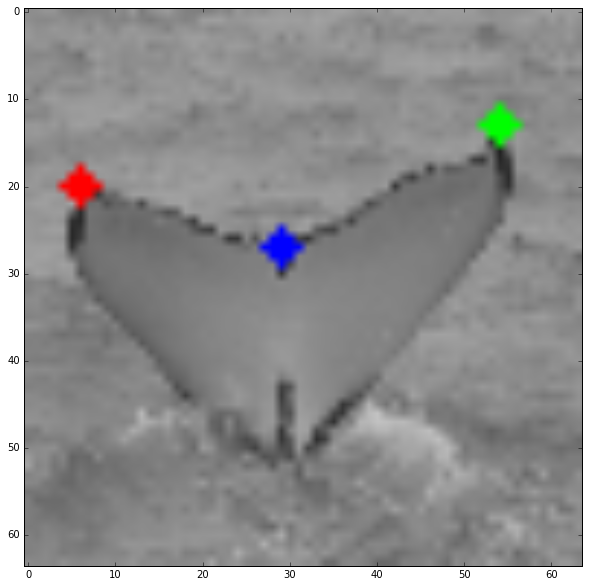

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
def display_kpgt(img, points):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (points[0,0], points[0,1]), 2, (255,0,0), -1) # left
    cv2.circle(color_img, (points[1,0], points[1,1]), 2, (0,255,0), -1) # right
    cv2.circle(color_img, (points[2,0], points[2,1]), 2, (0,0,255), -1) # notch
    plt.figure(figsize=(10,10))
    plt.imshow(color_img)

    
import random
ind = random.choice(range(len(train_kp_imgs)))
display_kpgt(train_kp_imgs[ind], train_kp_pts[ind])

In [15]:
from train_utils import save_dataset

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [16]:
dset_name = 'all_kpts_64_fixedx_clean'
save_dataset(join(dataset_loc,'Flukes/kpts/%s' % dset_name),
             (train_kp_imgs, train_kp_pts, train_kp_sizes), 
             (val_kp_imgs, val_kp_pts, val_kp_sizes), 
             (test_kp_imgs, test_kp_pts, test_kp_sizes), grey=True)


[util_io] * save_cPkl(u'.../all_kpts_64_fixedx_clean/train.pkl', data)
[util_io] * save_cPkl(u'.../all_kpts_64_fixedx_clean/val.pkl', data)
[util_io] * save_cPkl(u'.../all_kpts_64_fixedx_clean/test.pkl', data)
[util_io] * save_cPkl(u'.../all_kpts_64_fixedx_clean/meanstd.pkl', data)
Took 0.02 seconds
